In [131]:
import torch 
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from matplotlib.pyplot import figure

In [114]:
df = pd.read_excel(r'data.xlsx')

df_data = df.iloc[:,1:25].values
print(df_data.shape)
print(len(df_data))


(366, 24)
366


In [128]:
df_data = df_data.reshape(-1)
hours = np.linspace(0,8784, 8784)
hours

array([0.00000000e+00, 1.00011386e+00, 2.00022771e+00, ...,
       8.78199977e+03, 8.78299989e+03, 8.78400000e+03])

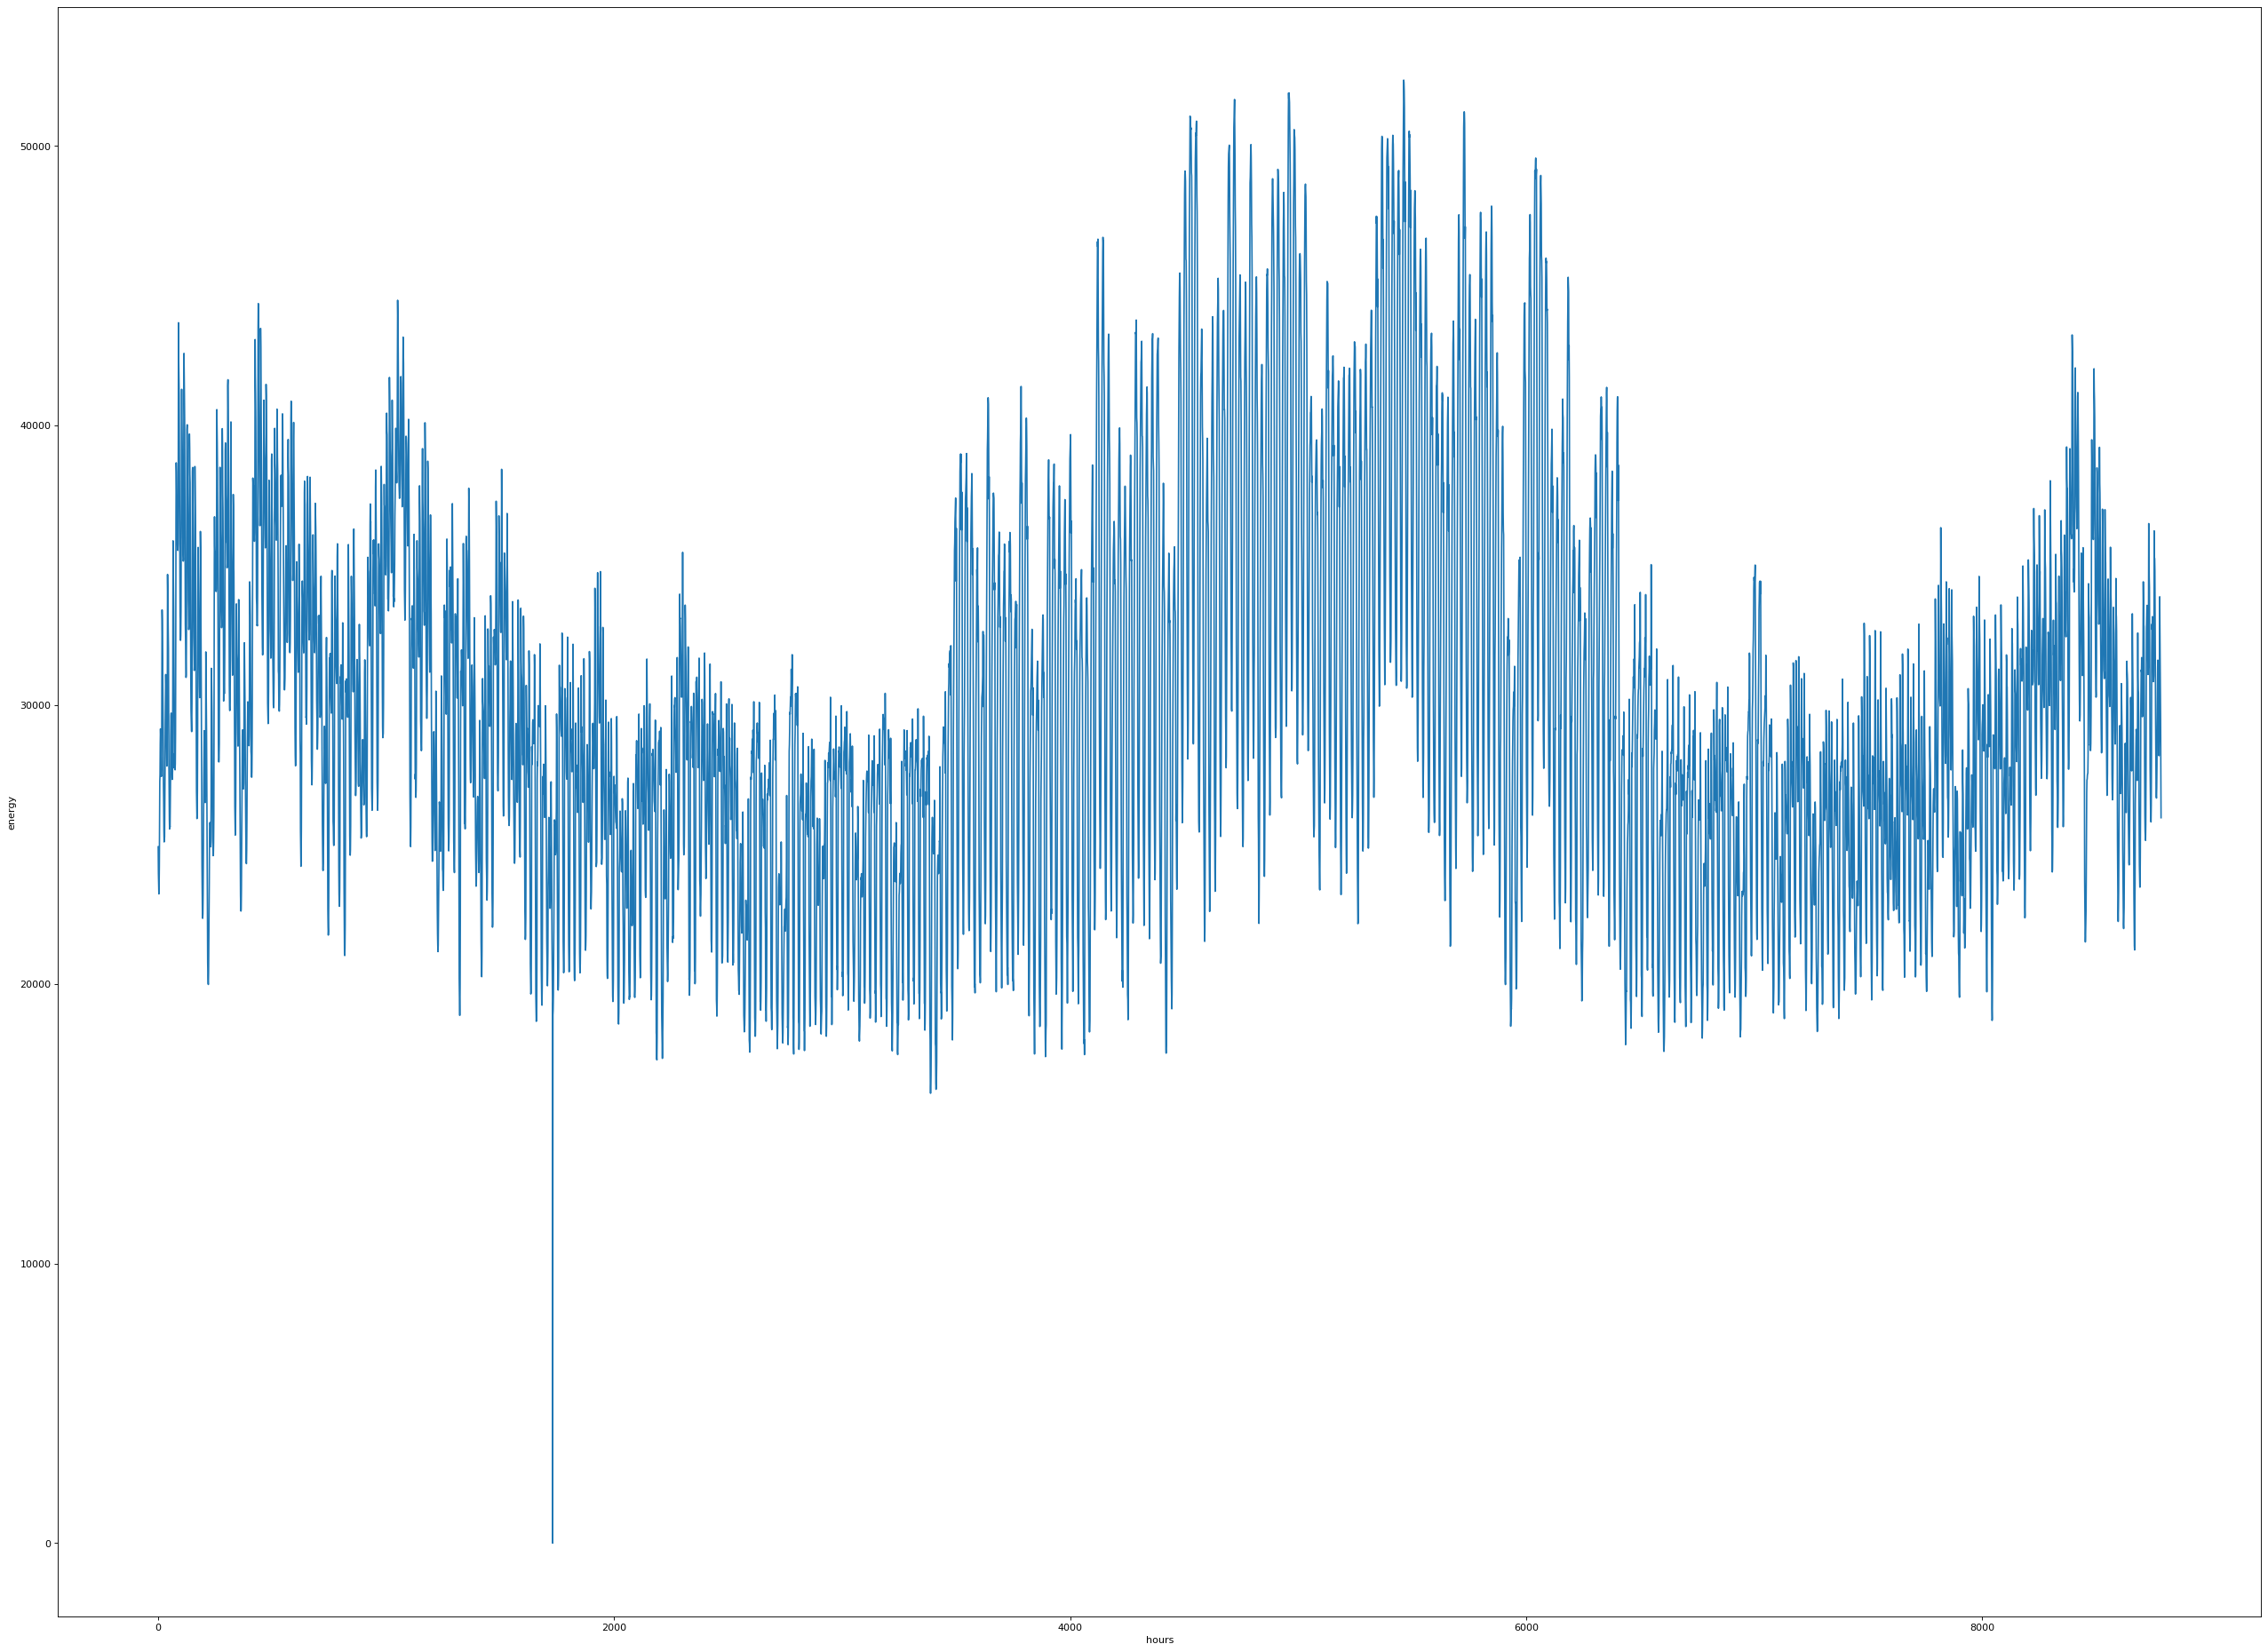

In [135]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')
plt.plot(hours, df_data)
plt.ylabel('energy')
plt.xlabel('hours')

plt.show()


In [80]:
trainpercent = 80.
stopat = int(np.floor(len(df_data)*trainpercent/100.))
train_data = df_data[:stopat]
test_data = df_data[stopat:]

In [109]:
test_data = test_data.reshape(1, -1)

In [104]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_data_norm = scaler.fit_transform(train_data.reshape(-1,1))
train_data_norm = train_data_norm.reshape(1,-1)

In [110]:
print(test_data.shape)
print(train_data_norm.shape)

(1, 1757)
(1, 7027)


In [113]:
train_data_norm = torch.FloatTensor(train_data_norm).view(-1)
print(train_data_norm)
print(train_data_norm.shape)


tensor([-0.0481, -0.0843, -0.1018,  ...,  0.3151,  0.2971,  0.3132])
torch.Size([7027])


In [29]:
train_window = 24

In [30]:
def create_io_seq(input_data, tw):
  inout_seq = [] 
  L = len(input_data)
  for i in range(L-tw): #7008-24=6984
    train_seq = input_data[i:i+tw] 
    train_label = input_data[i+tw:i+tw+1] # 24, 25, 26, ..., 7008?
    inout_seq.append((train_seq ,train_label))
  return inout_seq
  

In [31]:
train_io_seq = create_io_seq(train_data_norm, train_window)

In [52]:
print(len(train_io_seq[0][1]))

1


In [0]:
train_io_seq[:3] #6984 elts, each elt: (sequence of 24 hrs, label)

[(tensor([-0.0481, -0.0843, -0.1018, -0.1125, -0.0998, -0.0731, -0.0078,  0.0413,
           0.0507,  0.0934,  0.1131,  0.1029,  0.0719,  0.0521,  0.0480,  0.0574,
           0.1483,  0.2757,  0.2620,  0.2217,  0.1981,  0.1566,  0.1085,  0.0395]),
  tensor([0.0135])),
 (tensor([-0.0843, -0.1018, -0.1125, -0.0998, -0.0731, -0.0078,  0.0413,  0.0507,
           0.0934,  0.1131,  0.1029,  0.0719,  0.0521,  0.0480,  0.0574,  0.1483,
           0.2757,  0.2620,  0.2217,  0.1981,  0.1566,  0.1085,  0.0395,  0.0135]),
  tensor([-0.0244])),
 (tensor([-0.1018, -0.1125, -0.0998, -0.0731, -0.0078,  0.0413,  0.0507,  0.0934,
           0.1131,  0.1029,  0.0719,  0.0521,  0.0480,  0.0574,  0.1483,  0.2757,
           0.2620,  0.2217,  0.1981,  0.1566,  0.1085,  0.0395,  0.0135, -0.0244]),
  tensor([-0.0415]))]

In [43]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [44]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [0]:
epochs = 150

for i in range(epochs):
  for seq, labels in train_io_seq:
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

    y_pred = model(seq)

    single_loss = loss_function(y_pred, labels)
    single_loss.backward()
    optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

KeyboardInterrupt: ignored

In [0]:
fut_pred = 73

test_inputs = train_data_norm[-train_window:].tolist()
print(test_inputs)
print(len(test_inputs))

[-0.8427703976631165, -0.6464324593544006, -0.7550004720687866, -0.6182704567909241, -0.727336049079895, -0.7348989844322205, -0.8429694771766663, -0.7157925963401794, -0.7558960914611816, -0.7629615068435669, -0.7918201088905334, -0.7385809421539307, -0.6496168971061707, -0.7675390839576721, -0.7891332507133484, -0.6703154444694519, -0.7320131063461304, -0.7009652853012085, -0.6873320937156677, -0.6512090563774109, -0.8315255045890808, -0.7456463575363159, -0.508607804775238, -0.40531396865844727]
24


In [0]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [0]:
test_inputs[fut_pred:]


In [0]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

In [0]:
x = np.arange(294, 367, 1)
print(x)

[294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365
 366]


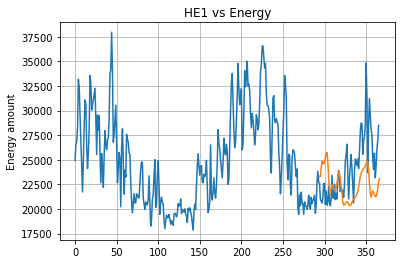

In [0]:
plt.title('HE1 vs Energy')
plt.ylabel('Energy amount')
plt.grid(True)
#plt.autoscale(axis='x', tight=True)
plt.plot(df_data)
plt.plot(x,actual_predictions)
plt.show()